In [ ]:
!pip install transformers==3.0.2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import logging
logging.basicConfig(level=logging.ERROR)

     |████████████████████████████████| 778kB 13.0MB/s 
     |████████████████████████████████| 870kB 49.0MB/s 
     |████████████████████████████████| 3.0MB 32.7MB/s 
     |████████████████████████████████| 1.2MB 54.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=13806a10b30583ceff024a37121c0ca641878582bc8ede6d12a5f4dab0ee782b
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('/content/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv')
df.head()

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [ ]:
def binary_encode(text):
  if text == 'hate':
    return 1
  else:
    return 0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


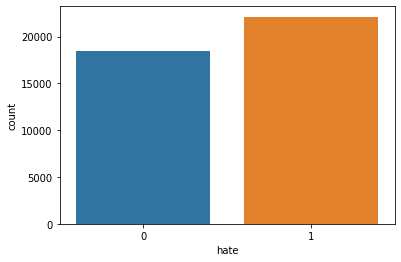

In [ ]:
df['hate'] = df.label.apply(binary_encode)

sns.countplot(df.hate)

In [ ]:
new_df = df[['text', 'hate']]

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.hate
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
testval_data=new_df.drop(train_data.index).reset_index(drop=True)
val_size = 0.5
val_data = testval_data.sample(frac=val_size,random_state=200)
test_data = testval_data.drop(val_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("VAL Dataset: {}".format(val_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
validation_set = SentimentData(val_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (40623, 2)
TRAIN Dataset: (32498, 2)
VAL Dataset: (4062, 2)
TEST Dataset: (4063, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768,1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = BertClass()
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def accuracy(preds, y):
    correct = (torch.round(torch.sigmoid(preds))==y).float()
    return correct.sum() #/ len(correct)


def train(epoch):
    tr_loss = 0
    val_loss = 0
    tr_n_correct = 0
    val_n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    nb_val_steps = 0
    nb_val_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        outputs = outputs.squeeze()
        targets = targets.type(torch.FloatTensor).to(device)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        tr_n_correct += accuracy(outputs.data, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    for _,data in tqdm(enumerate(val_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        outputs = outputs.squeeze()
        targets = targets.type(torch.FloatTensor).to(device)
        loss = loss_function(outputs, targets)
        val_loss += loss.item()
        val_n_correct += accuracy(outputs.data, targets)
        nb_val_steps += 1
        nb_val_examples+=targets.size(0)
    train_loss = tr_loss/nb_tr_steps
    train_acc = (tr_n_correct)/nb_tr_examples
    valid_loss = val_loss/nb_val_steps
    valid_acc = (val_n_correct)/nb_val_examples
    print(f"Training Loss Epoch: {train_loss}")
    print(f"Training Accuracy Epoch: {train_acc}")
    print(f"Validation Loss Epoch: {valid_loss}")
    print(f"Validation Accuracy Epoch: {valid_acc}")

    return train_loss, train_acc, valid_loss, valid_acc

In [ ]:
EPOCHS = 10
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
min_val_loss = np.inf
for epoch in range(EPOCHS):
    train_loss, train_acc, valid_loss, valid_acc = train(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    if valid_loss < min_val_loss:
      min_val_loss = valid_loss
      te_loss = 0
      te_n_correct = 0
      nb_te_steps = 0
      nb_te_examples = 0
      for _,data in tqdm(enumerate(testing_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        outputs = outputs.squeeze()
        targets = targets.type(torch.FloatTensor).to(device)
        loss = loss_function(outputs, targets)
        te_loss += loss.item()
        te_n_correct += accuracy(outputs.data, targets)
        nb_te_steps += 1
        nb_te_examples+=targets.size(0)
      test_loss = te_loss/nb_te_steps
      test_acc = (te_n_correct)/nb_te_examples
    print(f"Test Loss Epoch: {test_loss}")
    print(f"Test Accuracy Epoch: {test_acc}")
print(f"Final Test Loss: {test_loss}")
print(f"Final Test Accuracy {test_acc}")

4063it [25:41,  2.64it/s]
1016it [01:12, 14.05it/s]
2it [00:00, 14.46it/s]

Training Loss Epoch: 0.40482708027688574
Training Accuracy Epoch: 0.8098651766777039
Validation Loss Epoch: 0.29631169210554753
Validation Accuracy Epoch: 0.8682914972305298


1016it [01:12, 14.03it/s]
0it [00:00, ?it/s]

Test Loss Epoch: 0.31139067607733795
Test Accuracy Epoch: 0.8663549423217773


4063it [25:41,  2.64it/s]
1016it [01:12, 13.99it/s]
2it [00:00, 14.63it/s]

Training Loss Epoch: 0.21931673846957797
Training Accuracy Epoch: 0.9083020091056824
Validation Loss Epoch: 0.27687745272937253
Validation Accuracy Epoch: 0.8810930848121643


1016it [01:12, 14.02it/s]
0it [00:00, ?it/s]

Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


4063it [25:43,  2.63it/s]
1016it [01:12, 14.00it/s]
0it [00:00, ?it/s]

Training Loss Epoch: 0.13310349071657396
Training Accuracy Epoch: 0.9464274644851685
Validation Loss Epoch: 0.28000691510160824
Validation Accuracy Epoch: 0.8842934966087341
Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


4063it [25:43,  2.63it/s]
1016it [01:12, 14.04it/s]
0it [00:00, ?it/s]

Training Loss Epoch: 0.07932888099571246
Training Accuracy Epoch: 0.9698750376701355
Validation Loss Epoch: 0.3092602622822682
Validation Accuracy Epoch: 0.8852782249450684
Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


4063it [25:43,  2.63it/s]
1016it [01:12, 14.04it/s]
0it [00:00, ?it/s]

Training Loss Epoch: 0.0556342202627654
Training Accuracy Epoch: 0.980552613735199
Validation Loss Epoch: 0.34595590591518666
Validation Accuracy Epoch: 0.8874938488006592
Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


4063it [25:42,  2.63it/s]
1016it [01:12, 14.02it/s]
0it [00:00, ?it/s]

Training Loss Epoch: 0.042302578960203764
Training Accuracy Epoch: 0.9850451946258545
Validation Loss Epoch: 0.412028285756147
Validation Accuracy Epoch: 0.882570207118988
Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


4063it [25:41,  2.64it/s]
1016it [01:12, 14.02it/s]
0it [00:00, ?it/s]

Training Loss Epoch: 0.03422117043524479
Training Accuracy Epoch: 0.9880607724189758
Validation Loss Epoch: 0.4754460576173796
Validation Accuracy Epoch: 0.886509120464325
Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


4063it [25:42,  2.63it/s]
1016it [01:12, 14.01it/s]
0it [00:00, ?it/s]

Training Loss Epoch: 0.028381878255903128
Training Accuracy Epoch: 0.9902147650718689
Validation Loss Epoch: 0.49029425997123754
Validation Accuracy Epoch: 0.8847858309745789
Test Loss Epoch: 0.27787349570229075
Test Accuracy Epoch: 0.8835835456848145


2214it [14:00,  2.64it/s]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,EPOCHS+1,1), train_losses, label="Training")
plt.plot(np.arange(1,EPOCHS+1,1), valid_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1,EPOCHS+1,1), train_accuracies, label="Training")
plt.plot(np.arange(1,EPOCHS+1,1), valid_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()